In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import celerite
from celerite import terms
from scipy.optimize import minimize

import pandas as pd
import exoplanet as exo

from astropy.io import fits
from astropy.table import Table

from flareTools import FINDflare

From the celerite tutorial at<br>
<a href="https://celerite.readthedocs.io/en/stable/tutorials/first/">https://celerite.readthedocs.io/en/stable/tutorials/first/</a><br>

See <a href="https://ui.adsabs.harvard.edu/abs/2018MNRAS.474.2094A">Angus 2017</a> for a discussion of using gaussian processes to model stellar rotation

(-2.5, 2.5)

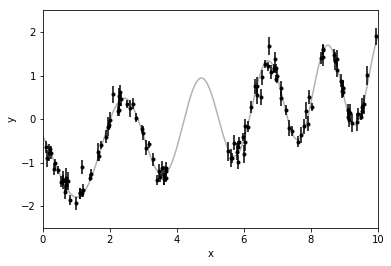

In [2]:
np.random.seed(42)

t = np.sort(np.append(
    np.random.uniform(0, 3.8, 57),
    np.random.uniform(5.5, 10, 68),
))  # The input coordinates must be sorted
yerr = np.random.uniform(0.08, 0.22, len(t))
y = 0.2 * (t-5) + np.sin(3*t + 0.1*(t-5)**2) + yerr * np.random.randn(len(t))

true_t = np.linspace(0, 10, 5000)
true_y = 0.2 * (true_t-5) + np.sin(3*true_t + 0.1*(true_t-5)**2)

plt.plot(true_t, true_y, "k", lw=1.5, alpha=0.3)
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(0, 10)
plt.ylim(-2.5, 2.5)

In [3]:
# A non-periodic component
Q = 1.0 / np.sqrt(2.0)
w0 = 3.0
S0 = np.var(y) / (w0 * Q)
bounds = dict(log_S0=(-15, 15), log_Q=(-15, 15), log_omega0=(-15, 15))
kernel = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                       bounds=bounds)
kernel.freeze_parameter("log_Q")  # We don't want to fit for "Q" in this term

# A periodic component
Q = 1.0
w0 = 3.0
S0 = np.var(y) / (w0 * Q)
kernel += terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                        bounds=bounds)

In [4]:
gp = celerite.GP(kernel, mean=np.mean(y))
gp.compute(t, yerr)  # You always need to call compute once.
print("Initial log likelihood: {0}".format(gp.log_likelihood(y)))

Initial log likelihood: -6.75659638262951


In [5]:
print("parameter_dict:\n{0}\n".format(gp.get_parameter_dict()))
print("parameter_names:\n{0}\n".format(gp.get_parameter_names()))
print("parameter_vector:\n{0}\n".format(gp.get_parameter_vector()))
print("parameter_bounds:\n{0}\n".format(gp.get_parameter_bounds()))

parameter_dict:
OrderedDict([('kernel:terms[0]:log_S0', -0.8497786656258695), ('kernel:terms[0]:log_omega0', 1.0986122886681098), ('kernel:terms[1]:log_S0', -1.1963522559058422), ('kernel:terms[1]:log_Q', 0.0), ('kernel:terms[1]:log_omega0', 1.0986122886681098)])

parameter_names:
('kernel:terms[0]:log_S0', 'kernel:terms[0]:log_omega0', 'kernel:terms[1]:log_S0', 'kernel:terms[1]:log_Q', 'kernel:terms[1]:log_omega0')

parameter_vector:
[-0.84977867  1.09861229 -1.19635226  0.          1.09861229]

parameter_bounds:
[(-15, 15), (-15, 15), (-15, 15), (-15, 15), (-15, 15)]



In [6]:
def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

initial_params = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()

r = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, args=(y, gp))
gp.set_parameter_vector(r.x)
print(r)

      fun: -16.563201709211853
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 6.82121026e-05,  1.13686838e-05, -5.11590770e-05,  8.52651283e-06,
       -3.58113539e-04])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 306
      nit: 30
   status: 0
  success: True
        x: array([ 3.2782789 , -2.02464554, -4.16135722,  2.34183996,  1.13554455])


In [7]:
gp.get_parameter_dict()

OrderedDict([('kernel:terms[0]:log_S0', 3.278278897453691),
             ('kernel:terms[0]:log_omega0', -2.024645541229001),
             ('kernel:terms[1]:log_S0', -4.161357218844049),
             ('kernel:terms[1]:log_Q', 2.341839956047069),
             ('kernel:terms[1]:log_omega0', 1.1355445484482187)])

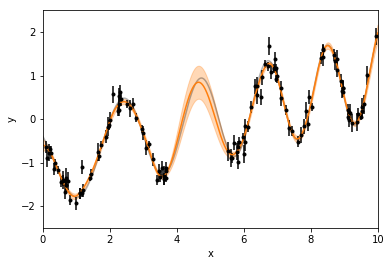

In [8]:
x = np.linspace(0, 10, 5000)
pred_mean, pred_var = gp.predict(y, x, return_var=True)
pred_std = np.sqrt(pred_var)

color = "#ff7f0e"
plt.plot(true_t, true_y, "k", lw=1.5, alpha=0.3)
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.plot(x, pred_mean, color=color)
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3,
                 edgecolor="none")
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(0, 10)
plt.ylim(-2.5, 2.5);

Try this with a TESS light curve

In [9]:
path = '/astro/store/gradscratch/tmp/scw7/tessData/lightcurves/sec7/'

# Anomalous flares were being detected at the gap edges in this light curve when
# using rolling median subtraction
f1 = 'tess2019006130736-s0007-0000000059764377-0131-s_lc.fits'

Text(0, 0.5, 'Flux [e-/s]')

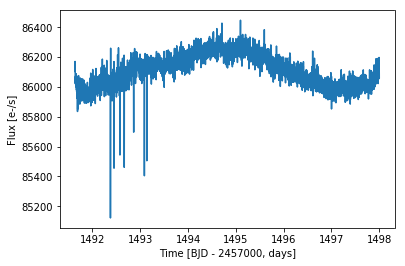

In [10]:
with fits.open(path+f1, mode='readonly') as hdulist:
    tess_bjds = hdulist[1].data['TIME']
    pdcsap_fluxes = hdulist[1].data['PDCSAP_FLUX']
    pdcsap_flux_error = hdulist[1].data['PDCSAP_FLUX_ERR']
    tess_quality = hdulist[1].data['QUALITY']
    
# Throw out NaN fluxes
mask = (~np.isnan(pdcsap_fluxes)) & (tess_bjds < 1498)
time = tess_bjds[mask]
flux = pdcsap_fluxes[mask]
quality = tess_quality[mask]
median = np.median(flux)
error = pdcsap_flux_error[mask]

plt.plot(time, flux)
plt.xlabel('Time [BJD - 2457000, days]')
plt.ylabel('Flux [e-/s]')

<ErrorbarContainer object of 3 artists>

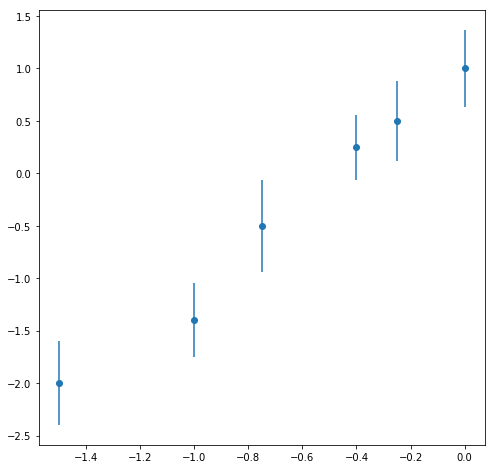

In [122]:
# Some simple made up data

xdata = [-1.5, -1, -0.75, -0.4, -0.25, 0]
ydata = [-2, -1.4, -0.5, 0.25, 0.5, 1]
ydataerr = [0.4, 0.35, 0.44, 0.31, 0.38, 0.37]

fig, axes = plt.subplots(figsize=(8,8))
axes.errorbar(xdata, ydata, yerr=yerr, fmt='o')

Play with squared exponential kernel

Initial log likelihood: -7.956822184586894
      fun: 7.141449776777412
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-8.88178420e-07,  1.50990331e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 30
      nit: 8
   status: 0
  success: True
        x: array([ 0.35168795, -0.40683866])
kernel:log_a 0.3516879497165276
kernel:log_c -0.40683866202618235


Text(0, 0.5, 'Flux [e-/s]')

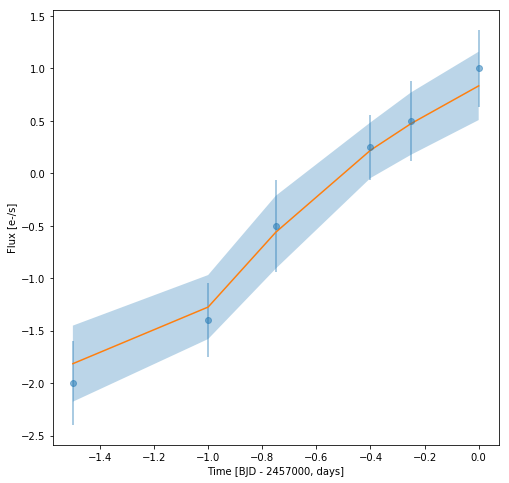

In [123]:
x = xdata
y = ydata
yerr = ydataerr

# k = a*exp(-c*tau)
a = 1 # Amplitude
c = 0.1 # Length scale
bounds = dict(log_a=(-15, 15), log_c=(-15, 15))
kernel = terms.RealTerm(log_a=np.log10(a), log_c=np.log10(c), bounds=bounds)

gp = celerite.GP(kernel, mean=np.mean(y))
gp.compute(x, yerr)
print("Initial log likelihood: {0}".format(gp.log_likelihood(y)))

from scipy.optimize import minimize

def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

initial_params = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()

r = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, args=(y, gp))
gp.set_parameter_vector(r.x)
print(r)

d = gp.get_parameter_dict()
for key, value in d.items():
    print(key, value)

pred_mean, pred_var = gp.predict(y, x, return_var=True)
pred_std = np.sqrt(pred_var)

fig, axes = plt.subplots(figsize=(8,8))
axes.errorbar(x, y, yerr=yerr, fmt='o', alpha=0.5)
axes.plot(x, pred_mean)
axes.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, alpha=0.3)
axes.set_xlabel('Time [BJD - 2457000, days]')
axes.set_ylabel('Flux [e-/s]')

Initial log likelihood: -37415.087814283885
      fun: 24661.36352466057
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.01164153, -0.01346052])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 63
      nit: 18
   status: 0
  success: True
        x: array([9.01127639, 0.31302408])
kernel:log_a 9.011276391436914
kernel:log_c 0.31302407650700925


Text(0, 0.5, 'Flux [e-/s]')

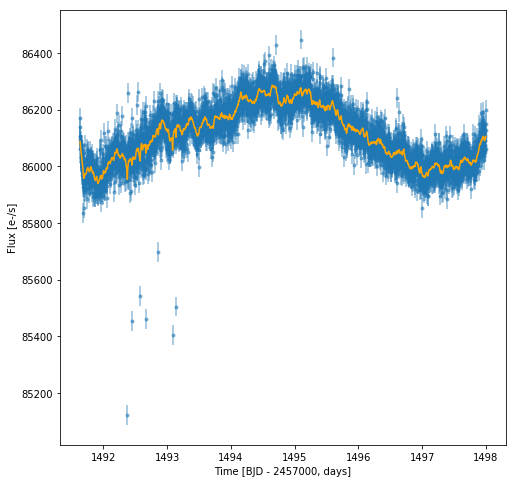

In [133]:
x = time
y = flux
yerr = error

# k = a*exp(-c*tau)
a = 1 # Amplitude
c = 0.1 # Length scale
bounds = dict(log_a=(-15, 15), log_c=(-15, 15))
kernel = terms.RealTerm(log_a=np.log10(a), log_c=np.log10(c), bounds=bounds)

gp = celerite.GP(kernel, mean=np.mean(y))
gp.compute(x, yerr)
print("Initial log likelihood: {0}".format(gp.log_likelihood(y)))

from scipy.optimize import minimize

def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

initial_params = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()

r = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, args=(y, gp))
gp.set_parameter_vector(r.x)
print(r)

d = gp.get_parameter_dict()
for key, value in d.items():
    print(key, value)

pred_mean, pred_var = gp.predict(y, x, return_var=True)
pred_std = np.sqrt(pred_var)

fig, axes = plt.subplots(figsize=(8,8))
axes.errorbar(x, y, yerr=yerr, fmt='.', alpha=0.5)
axes.plot(x, pred_mean, color='orange', zorder=3)
axes.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, alpha=0.3)
axes.set_xlabel('Time [BJD - 2457000, days]')
axes.set_ylabel('Flux [e-/s]')

In [11]:
# A non-periodic component
Q = 1.0 / np.sqrt(2.0)
w0 = 3.0
S0 = np.var(y) / (w0 * Q)
bounds = dict(log_S0=(-15, 15), log_Q=(-15, 15), log_omega0=(-15, 15))
kernel = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                       bounds=bounds)
#kernel.freeze_parameter("log_Q")  # We don't want to fit for "Q" in this term

# A periodic component
Q = 1.0
w0 = 3
S0 = np.var(y) / (w0 * Q)
kernel += terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                        bounds=bounds)

In [12]:
gp = celerite.GP(kernel, mean=np.mean(flux))
gp.compute(time, error)  # You always need to call compute once.
print("Initial log likelihood: {0}".format(gp.log_likelihood(flux)))

Initial log likelihood: -33949.48351988763


In [13]:
gp.get_parameter_dict()

OrderedDict([('kernel:terms[0]:log_S0', -0.8497786656258695),
             ('kernel:terms[0]:log_Q', -0.34657359027997275),
             ('kernel:terms[0]:log_omega0', 1.0986122886681098),
             ('kernel:terms[1]:log_S0', -1.1963522559058422),
             ('kernel:terms[1]:log_Q', 0.0),
             ('kernel:terms[1]:log_omega0', 1.0986122886681098)])

In [14]:
pred_mean, pred_var = gp.predict(flux, time, return_var=True)
pred_std = np.sqrt(pred_var)

Text(0, 0.5, 'Flux [e-/s]')

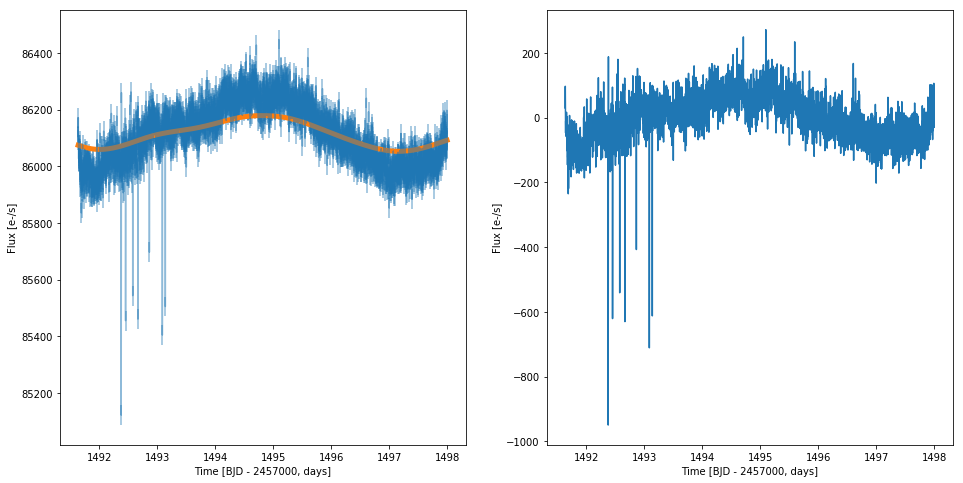

In [15]:
fig, axes = plt.subplots(figsize=(16,8), nrows=1, ncols=2)
axes[0].errorbar(time, flux, yerr=error, alpha=0.5)
axes[0].plot(time, pred_mean, lw=5)
axes[0].set_xlabel('Time [BJD - 2457000, days]')
axes[0].set_ylabel('Flux [e-/s]')

axes[1].errorbar(time, flux-pred_mean)
axes[1].set_xlabel('Time [BJD - 2457000, days]')
axes[1].set_ylabel('Flux [e-/s]')

In [16]:
start_i, stop_i = FINDflare(flux-pred_mean, error, avg_std=False, N1=4, N2=2, N3=5)
print(str(len(start_i)) + ' flares found')

0 flares found


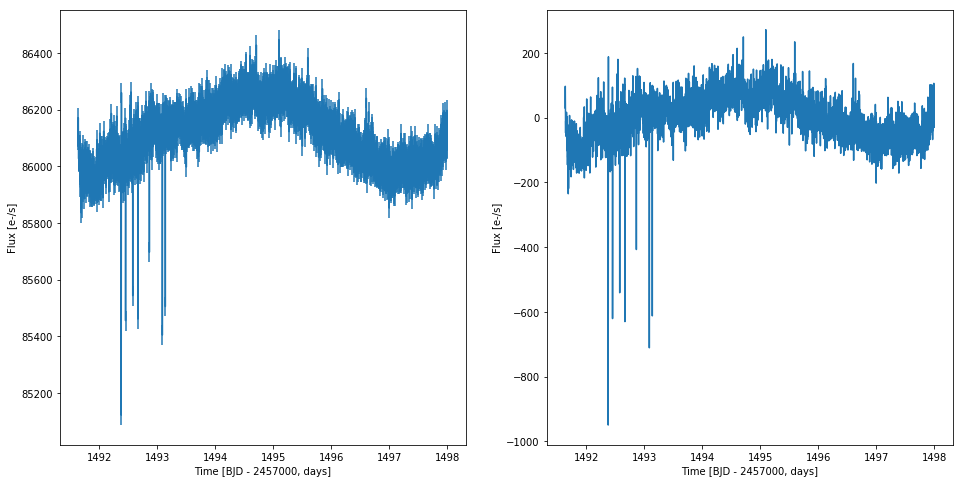

In [17]:
fig, axes = plt.subplots(figsize=(16,8), nrows=1, ncols=2)
axes[0].errorbar(time, flux, yerr=error)
axes[0].set_xlabel('Time [BJD - 2457000, days]')
axes[0].set_ylabel('Flux [e-/s]')

axes[1].errorbar(time, flux-pred_mean)
axes[1].set_xlabel('Time [BJD - 2457000, days]')
axes[1].set_ylabel('Flux [e-/s]')

for idx in range(len((start_i))):
    l = 'Flare?' if idx == 0 else '_nolabel_'
    axes[0].plot(time[start_i[idx]:stop_i[idx]], 
              flux[start_i[idx]:stop_i[idx]], 'o', color='orange', label=l)